In [354]:
import nltk,re,time,umap,collections,os,string,sys,mlflow
sys.path.append(os.path.abspath(".."))
from modules import utils,modeling

from sentence_transformers import SentenceTransformer
import plotly.express as px
import pandas as pd
from sklearn.decomposition import PCA

from sklearn.metrics import completeness_score,homogeneity_score, v_measure_score,normalized_mutual_info_score,adjusted_mutual_info_score,silhouette_score
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from matplotlib_venn import venn2, venn2_circles
from matplotlib import pyplot as plt

from hdbscan import HDBSCAN
from sentence_transformers import models
from sklearn.preprocessing import normalize
from transformers import AutoModel, AutoTokenizer
from torch import nn
import mlflow.sklearn
from  mlflow.tracking import MlflowClient
from sklearn.preprocessing import StandardScaler



#tokenizer = AutoTokenizer.from_pretrained("dbmdz/bert-base-german-cased")
%reload_ext utils
%reload_ext modeling

%matplotlib inline
%load_ext autoreload
%autoreload 2

try:
    remote_server="http://ec2-18-184-134-25.eu-central-1.compute.amazonaws.com"
    client = MlflowClient(remote_server)
    mlflow.set_tracking_uri(remote_server)
except ConnectionError as ConnErr:
    print("Could not reach remote MLflow service")
    client = MlflowClient()
    mlflow.set_experiment("Windowed Clustering")


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [64]:
df= utils.load_text_data("../data/2k_22-10.csv").head(2000)

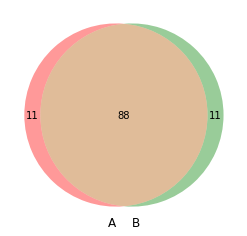

In [358]:
total = 110
overlap_ratio = 0.9
df_a,df_b = df.head(total).sample(round(total*overlap_ratio)),df.head(total).sample(round(total*overlap_ratio))
sets = [set(df_a.index.values), set(df_b.index.values)]
venn2(sets)
print()

In [359]:
pdf_a = utils.preprocess_articles_for_bert(df_a)
pdf_b = utils.preprocess_articles_for_bert(df_b)

# Instead of spliting the data into two versions of the data just cluster twice the same data and then match them ...
unique_for_a= len(((sets[0] ^ sets[1]) & sets[0]) )
unique_for_b= len(((sets[0] ^ sets[1]) & sets[1]) )
common_for_both = len(sets[0] & sets[1])

In [360]:
#load BERT model from Hugging Face
#model_name= "T-Systems-onsite/cross-en-de-roberta-sentence-transformer"
#model_name= "T-Systems-onsite/bert-german-dbmdz-uncased-sentence-stsb"
model_name= "T-Systems-onsite/german-roberta-sentence-transformer-v2"

word_embedding_model = models.Transformer(model_name)
try:
    pass
    mlflow.set_tag("model_name",model_name)
    mlflow.set_tag("max_pooling",max_pooling)
    mlflow.set_tag("Cluster Description Column","text_ne")
except ConnectionError as ConnErr:
    print("Could not reach service")
    

In [361]:
embeddings_a = modeling.get_sentence_embeddings(pdf_a,word_embedding_model)
embeddings_b = modeling.get_sentence_embeddings(pdf_b,word_embedding_model)


--- Embedding dimension 768
--- 99 Documnets encoded 9.07549786567688 seconds ---



--- Embedding dimension 768
--- 99 Documnets encoded 9.207638025283813 seconds ---


In [362]:
N_COMPONENTS=128
alpha=0.825
min_cluster_size=3
min_samples=3
n_neighbors=42

uamp_a, clusters_a = modeling.cluster_and_reduce(embeddings_a,n_components_clustering=N_COMPONENTS, min_cluster_size=min_cluster_size,n_neighbors=n_neighbors, 
                                                                             min_samples= min_samples,alpha=alpha)

uamp_b, clusters_b = modeling.cluster_and_reduce(embeddings_b,n_components_clustering=N_COMPONENTS,min_cluster_size=min_cluster_size,n_neighbors=n_neighbors, 
                                                                             min_samples= min_samples,alpha=alpha)

>> Reducing dimensionality from 768 to 128 ...
>> Clustering...
>> --- Done in 1.8 seconds ---
>> Reducing dimensionality from 768 to 128 ...
>> Clustering...
>> --- Done in 1.6 seconds ---


In [364]:
docs_df_a = utils.relink_data_after_clustering(uamp_a,df_a,clusters_a)
docs_df_b = utils.relink_data_after_clustering(uamp_b,df_b,clusters_b)


# For every topic collect all the article and join their texts (preprocessed) , raw texts, 
docs_a_per_topic = docs_df_a.groupby(['topic_number'], as_index = False).agg({'raw_text': ' '.join,
                                                                   'headline': '. '.join,
                                                                    "kicker_headline_ne":lambda x: (utils.flatten([utils.parse_google_named_entities(el) for el in x ])),
                                                                      "text_ne":lambda x: (utils.flatten([utils.parse_google_named_entities(el) for el in x ])),
                                                                        "seo_title_ne":lambda x: (utils.flatten([utils.parse_google_named_entities(el) for el in x ]))

                                                                  }).set_index("topic_number")


# For every topic collect all the article and join their texts (preprocessed) , raw texts, 
docs_b_per_topic = docs_df_b.groupby(['topic_number'], as_index = False).agg({'raw_text': ' '.join,
                                                                   'headline': '. '.join,
                                                                    
                                                                    "kicker_headline_ne":lambda x: (utils.flatten([utils.parse_google_named_entities(el) for el in x ])),
                                                                      "text_ne":lambda x: (utils.flatten([utils.parse_google_named_entities(el) for el in x ])),
                                                                     "seo_title_ne":lambda x: (utils.flatten([utils.parse_google_named_entities(el) for el in x ]))
                                                                  }).set_index("topic_number")



Outliers: 8 | Clustered: 91 | 0.9191919191919192 
 Cluster count: 16 
Outliers: 11 | Clustered: 88 | 0.8888888888888888 
 Cluster count: 13 


In [365]:

docs_a_per_topic.head()

,raw_text,headline,kicker_headline_ne,text_ne,seo_title_ne
topic_number,,,,,
-1,Innerhalb von nur wenigen Minuten rauben zwei ...,Überwachungskamera zeigt Blitz-Raub!. Hoffenhe...,"[{'text': 'Überfall', 'type': 'EVENT'}, {'text...","[{'text': 'Juweliergeschäft', 'type': 'OTHER'}...","[{'text': 'Überwachungskamera', 'type': 'CONSU..."
0,In den USA zeichnet sich eine rekordverdächtig...,USA steuern auf höchste Wahlbeteiligung seit ü...,"[{'text': 'Kampf', 'type': 'EVENT'}, {'text': ...","[{'text': 'Wahl-Projektes', 'type': 'OTHER'}, ...","[{'text': 'Trump', 'type': 'OTHER'}, {'text': ..."
1,Insgesamt 16 Jahre spielte Benedikt Höwedes (3...,"Wichtig, im Derby „mit der richtigen Härte zu...","[{'text': 'Ex-Schalker Höwedes', 'type': 'PERS...","[{'text': 'Derbys', 'type': 'OTHER'}, {'text':...","[{'text': 'Interview', 'type': 'EVENT'}, {'tex..."
2,Kann Köln diesmal gewinnen? Der FC ist aktuell...,So sehen Sie Stuttgart gegen Köln live im TV. ...,"[{'text': 'TV', 'type': 'OTHER'}, {'text': 'Bu...","[{'text': 'FC', 'type': 'ORGANIZATION'}, {'tex...","[{'text': 'Bundesliga', 'type': 'ORGANIZATION'..."
3,Jetzt steht Boris Becker das Wasser bis zum Ha...,„Er hat einen schlechten Charakter!“. Schulles...,"[{'text': 'Staatsanwältin', 'type': 'PERSON'},...","[{'text': 'Wasser', 'type': 'OTHER'}, {'text':...","[{'text': 'Staatsanwältin', 'type': 'PERSON'},..."


In [366]:

docs_b_per_topic.head()

,raw_text,headline,kicker_headline_ne,text_ne,seo_title_ne
topic_number,,,,,
-1,Derby-Debüt für den Torwart-Dänen! Frankfurt-L...,„Wir haben die Ultra-Botschaft verstanden!“. F...,"[{'text': 'Torwart', 'type': 'PERSON'}, {'text...","[{'text': 'Derby-Debüt', 'type': 'OTHER'}, {'t...","[{'text': 'Ultra-Botschaft', 'type': 'OTHER'},..."
0,Dritte und letzte TV-Schlacht im Kampf um das ...,Trump und Biden fetzen sich ums Weiße Haus. Di...,"[{'text': 'TV-Schlacht', 'type': 'EVENT'}, {'t...","[{'text': 'Dritte', 'type': 'OTHER'}, {'text':...","[{'text': 'TV-Duell', 'type': 'CONSUMER_GOOD'}..."
1,Jeden Donnerstag gibt es bei BILD eine neue Di...,Stehen wir kurz vor dem „Corona-Burn-out“?. Un...,"[{'text': 'Psychologin', 'type': 'PERSON'}, {'...","[{'text': 'Diskussionsrunde', 'type': 'OTHER'}...","[{'text': 'Leute', 'type': 'PERSON'}, {'text':..."
2,Der 1. FC Magdeburg schon wieder unter Druck! ...,"Ernst ist HoßmangsHoffnungsträger. Wichtig, im...","[{'text': 'FCM', 'type': 'ORGANIZATION'}, {'te...","[{'text': 'Druck', 'type': 'OTHER'}, {'text': ...","[{'text': 'FCM', 'type': 'ORGANIZATION'}, {'te..."
3,Unfassbar! Oldenburg – Ein Staatsanwalt hat si...,Staatsanwalt rechtfertigt das Schlagen von Kin...,"[{'text': 'Staatsanwalt', 'type': 'PERSON'}, {...","[{'text': 'Täter', 'type': 'PERSON'}, {'text':...","[{'text': 'Staatsanwalt', 'type': 'PERSON'}, {..."


In [410]:
ctrs=[]
for topic in docs_a_per_topic.index.values: # Go over topic labels 
    text_entities = [elem["text"] for elem in docs_a_per_topic.loc[topic]["text_ne"] if not elem['type'] =="NUMBER" and not elem['type'] =="COMMON"]
    seo_title_entities = [elem["text"] for elem in docs_a_per_topic.loc[topic]["seo_title_ne"] if not elem['type'] =="NUMBER"]*2
    kicker_headline_entities = [elem["text"] for elem in docs_a_per_topic.loc[topic]["kicker_headline_ne"] if not elem['type'] =="NUMBER"] *3
    
    counted_word_occurances = collections.Counter(text_entities+seo_title_entities+kicker_headline_entities).most_common()[:5]
    ctrs.append(counted_word_occurances)
dict_with_top_words = {k:v  for k,v in  zip(docs_a_per_topic.index.values,ctrs)}   
merged_embeddings = modeling.get_sentence_embeddings(docs_a_per_topic["headline"].values,word_embedding_model,False)

cluster_labels_google_a = pd.DataFrame(
    zip(docs_a_per_topic.index.values,["| ".join([word[0] for word in word_score]) for word_score in ctrs],merged_embeddings),columns=["Topic","TopWords","merged_headline_embedding"])\
    .sort_values(by="Topic").set_index("Topic")
cluster_labels_google_a


--- Embedding dimension 768
--- 17 Documnets encoded 1.1336669921875 seconds ---


,TopWords,merged_headline_embedding
Topic,,
-1,Überwachungskamera| Love Island| Modell| Gedäc...,"[0.10836969, 0.19750257, 0.1819586, -0.4376888..."
0,Trump| Biden| Wahl| US| TV-Duell,"[0.04714764, -0.054574538, -0.083157435, -0.08..."
1,Derby| Interview| Härte| Führungsgremien| DFB,"[0.012758665, 0.13067657, -0.03269364, 0.29150..."
2,Köln| Spiel| Bundesliga| Mainz| Verlierer,"[0.033184182, -0.0019663537, 0.17483355, -0.22..."
3,Boris Becker| Staatsanwältin| Spiel| Darmstadt...,"[0.08226981, 0.14543241, -0.021904884, 0.52238..."
4,HSV| Liga| Trainer| Spiel| Hoffnung,"[0.030704863, 0.099489436, -0.081577934, -0.36..."
5,Wohnung| Berlin| Laura| Wendler| Florida,"[-0.16132988, 0.19298685, 0.008522944, -0.2345..."
6,Maske| Corona| Sport| Experten| Fragen,"[-0.11082637, 0.10200681, 0.059834134, -0.3503..."
7,Trainer| Europa| Clásico| MOTZivator| Müller,"[0.17447342, 0.19376609, 0.21719265, 0.4868829..."


In [411]:
ctrs=[]
for topic in docs_b_per_topic.index.values: # Go over topic labels 
    text_entities = [elem["text"] for elem in docs_b_per_topic.loc[topic]["text_ne"] if not elem['type'] =="NUMBER" and not elem['type'] =="COMMON" ]
    seo_title_entities = [elem["text"] for elem in docs_b_per_topic.loc[topic]["seo_title_ne"] if not elem['type'] =="NUMBER"]*2
    kicker_headline_entities = [elem["text"] for elem in docs_b_per_topic.loc[topic]["kicker_headline_ne"] if not elem['type'] =="NUMBER"]*2
    
    counted_word_occurances = collections.Counter(text_entities+seo_title_entities+kicker_headline_entities).most_common()[:5]
    ctrs.append(counted_word_occurances)
    
merged_embeddings = modeling.get_sentence_embeddings(docs_b_per_topic["headline"].values,word_embedding_model,False)
    
dict_with_top_words = {k:v  for k,v in  zip(docs_b_per_topic.index.values,ctrs)}   
cluster_labels_google_b = pd.DataFrame(
    zip(docs_b_per_topic.index.values,["| ".join([word[0] for word in word_score]) for word_score in ctrs],merged_embeddings),columns=["Topic","TopWords","merged_headline_embedding"])\
    .sort_values(by="Topic").set_index("Topic")
cluster_labels_google_b


--- Embedding dimension 768
--- 14 Documnets encoded 1.1740999221801758 seconds ---


,TopWords,merged_headline_embedding
Topic,,
-1,Hoffnung| Corona| Fan-Entscheidung| Anpfiff| S...,"[0.08396707, 0.23185411, 0.12502433, -0.215837..."
0,Trump| Biden| Wahl| Kampf| Weiße Haus,"[0.102730684, 0.10987485, -0.11761336, -0.0081..."
1,Corona-Burn-out| Laura| Wendler| Florida| E-Au...,"[-0.10827793, 0.107472144, -0.08827114, 0.0485..."
2,Derby| Wiesbaden| Ernst| Interview| BVB,"[0.047130138, 0.11656971, -0.023503425, 0.0001..."
3,Corona| Test| US| Spiel| Appell,"[-0.15274173, 0.48853865, 0.012360713, -0.0892..."
4,Trainer| Bundesliga| Europa| Peter Kadiru| Gol...,"[0.20464472, 0.20712599, 0.21072268, 0.6167453..."
5,Dresden| Terrorist| Terroristen| Frau| Existenz,"[-0.043853942, 0.06791661, 0.03711653, -0.4597..."
6,Russland| Einbrecher| Kunstwerk| Sanktionen| EU,"[0.20283867, -0.037712242, 0.23060928, -0.5374..."
7,Biografie| Gedächtnisschwund| Boris Becker| An...,"[-0.06079126, 0.10737395, -0.036305595, 0.0991..."


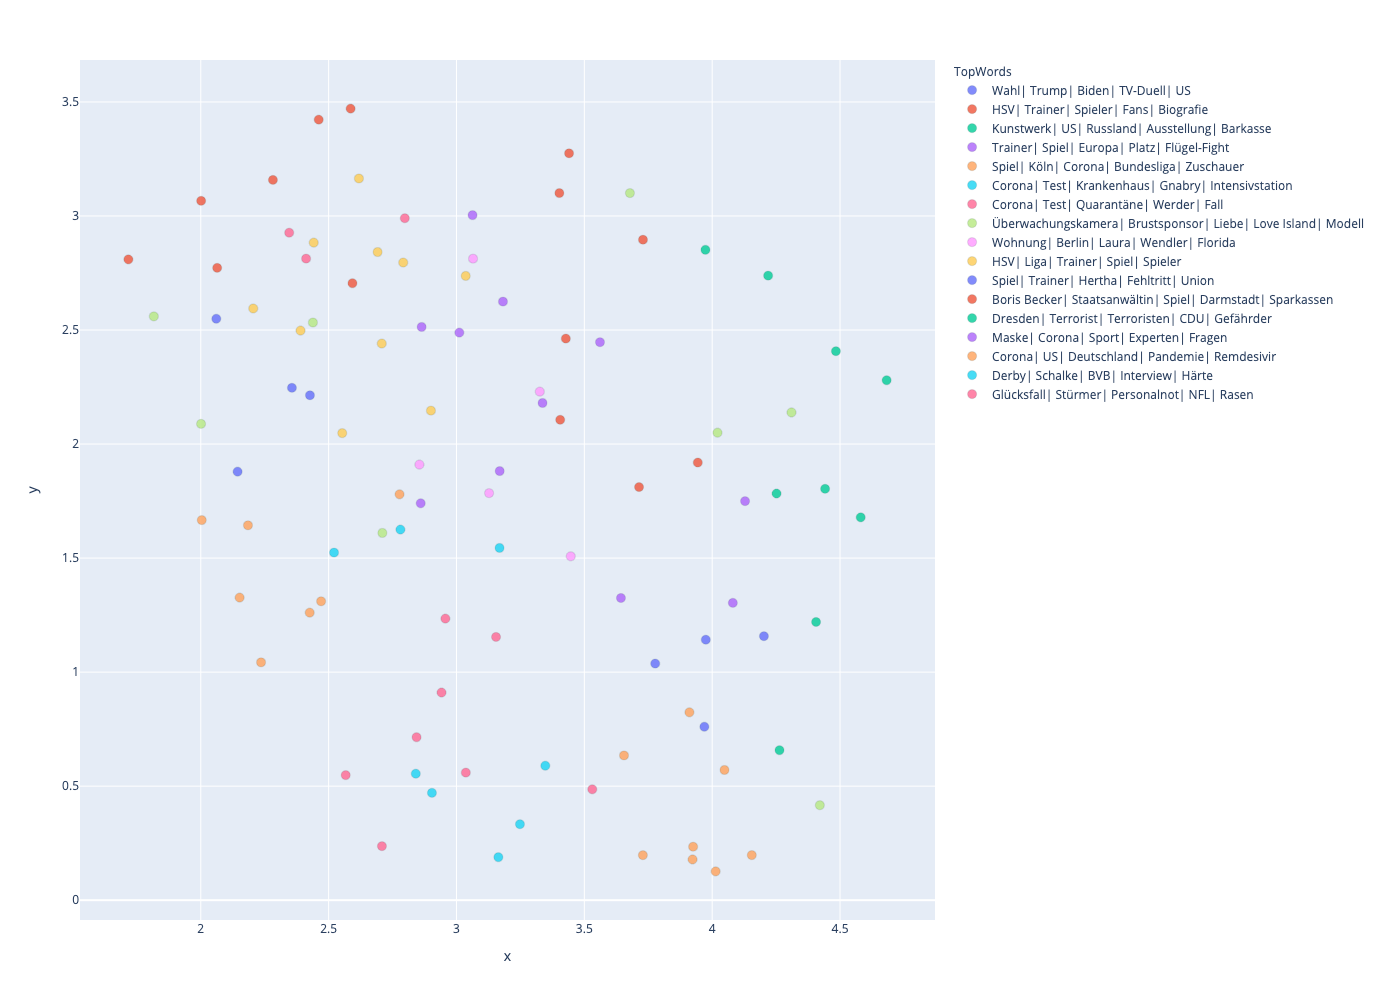

In [377]:
results=pd.merge(docs_df_a,cluster_labels_google_a.reset_index(),left_on="topic_number",right_on = "Topic")
fig = px.scatter(results, x="x", y="y", hover_name="headline", hover_data=["created_at","TopWords","topic_number"], color="TopWords",opacity=0.8)

fig.update_traces(marker=dict(size=9,
                              line=dict(width=0.15,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))
fig["layout"].pop("updatemenus")

fig.update_layout(height=1000)
fig.show()

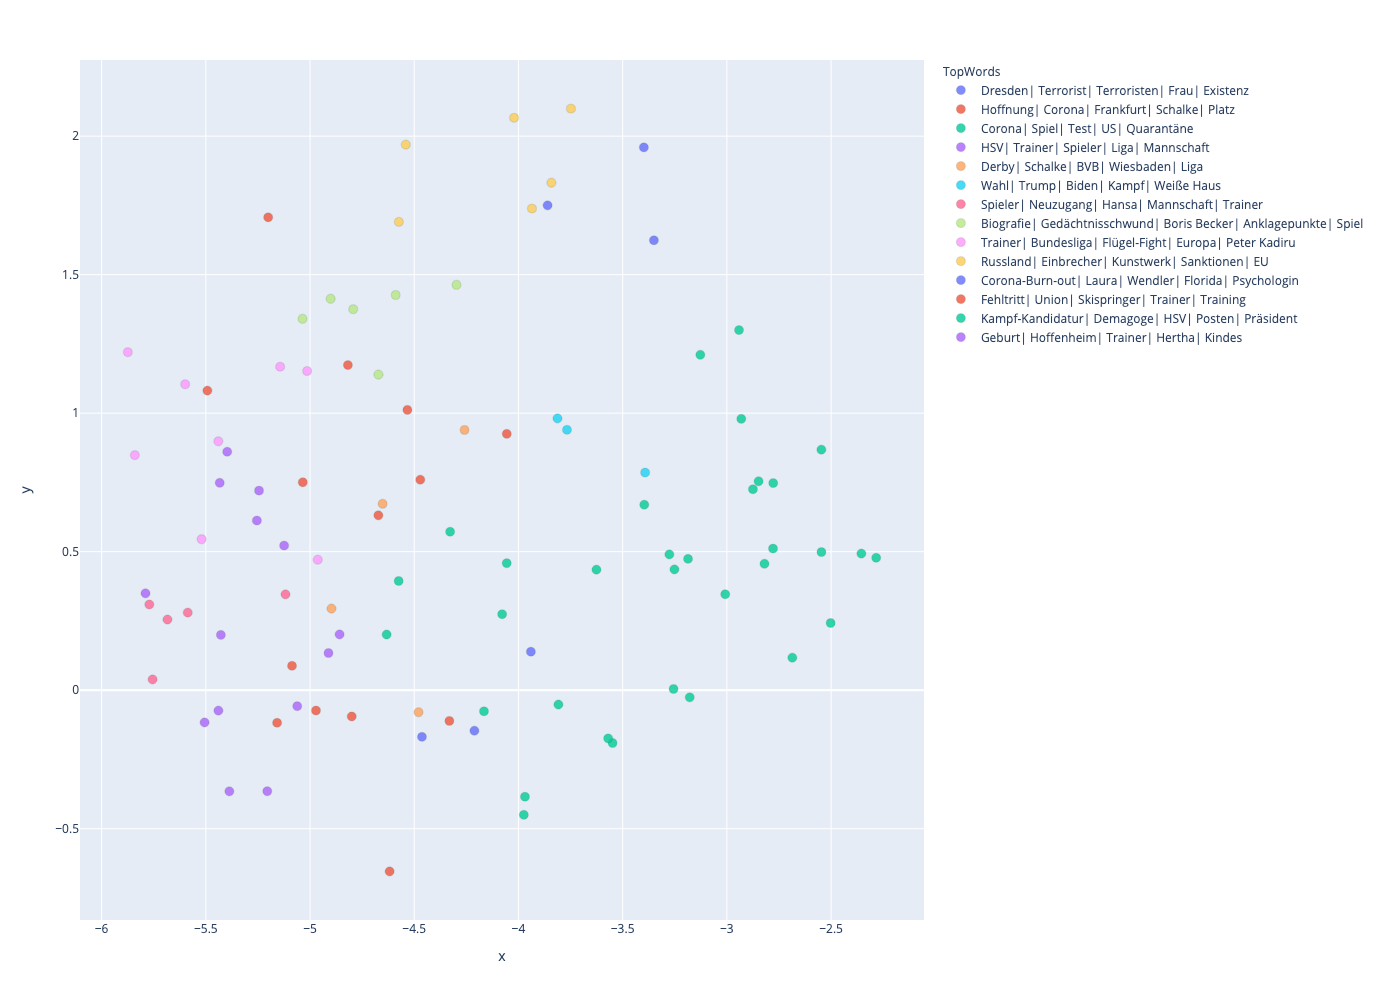

In [378]:
results=pd.merge(docs_df_b,cluster_labels_google_b.reset_index(),left_on="topic_number",right_on = "Topic")
fig = px.scatter(results, x="x", y="y", hover_name="headline", hover_data=["created_at","TopWords","topic_number"], color="TopWords", opacity=0.8)

fig.update_traces(marker=dict(size=9,
                              line=dict(width=0.15,
                                        color='DarkSlateGrey')),
                  selector=dict(mode='markers'))
fig["layout"].pop("updatemenus")

fig.update_layout(height=1000)
fig.show()

In [435]:
from scipy.spatial.distance import cosine
from scipy.spatial.distance import cdist


(8, 3)

In [470]:
cluster_labels_google_a.index.to_list()

[-1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

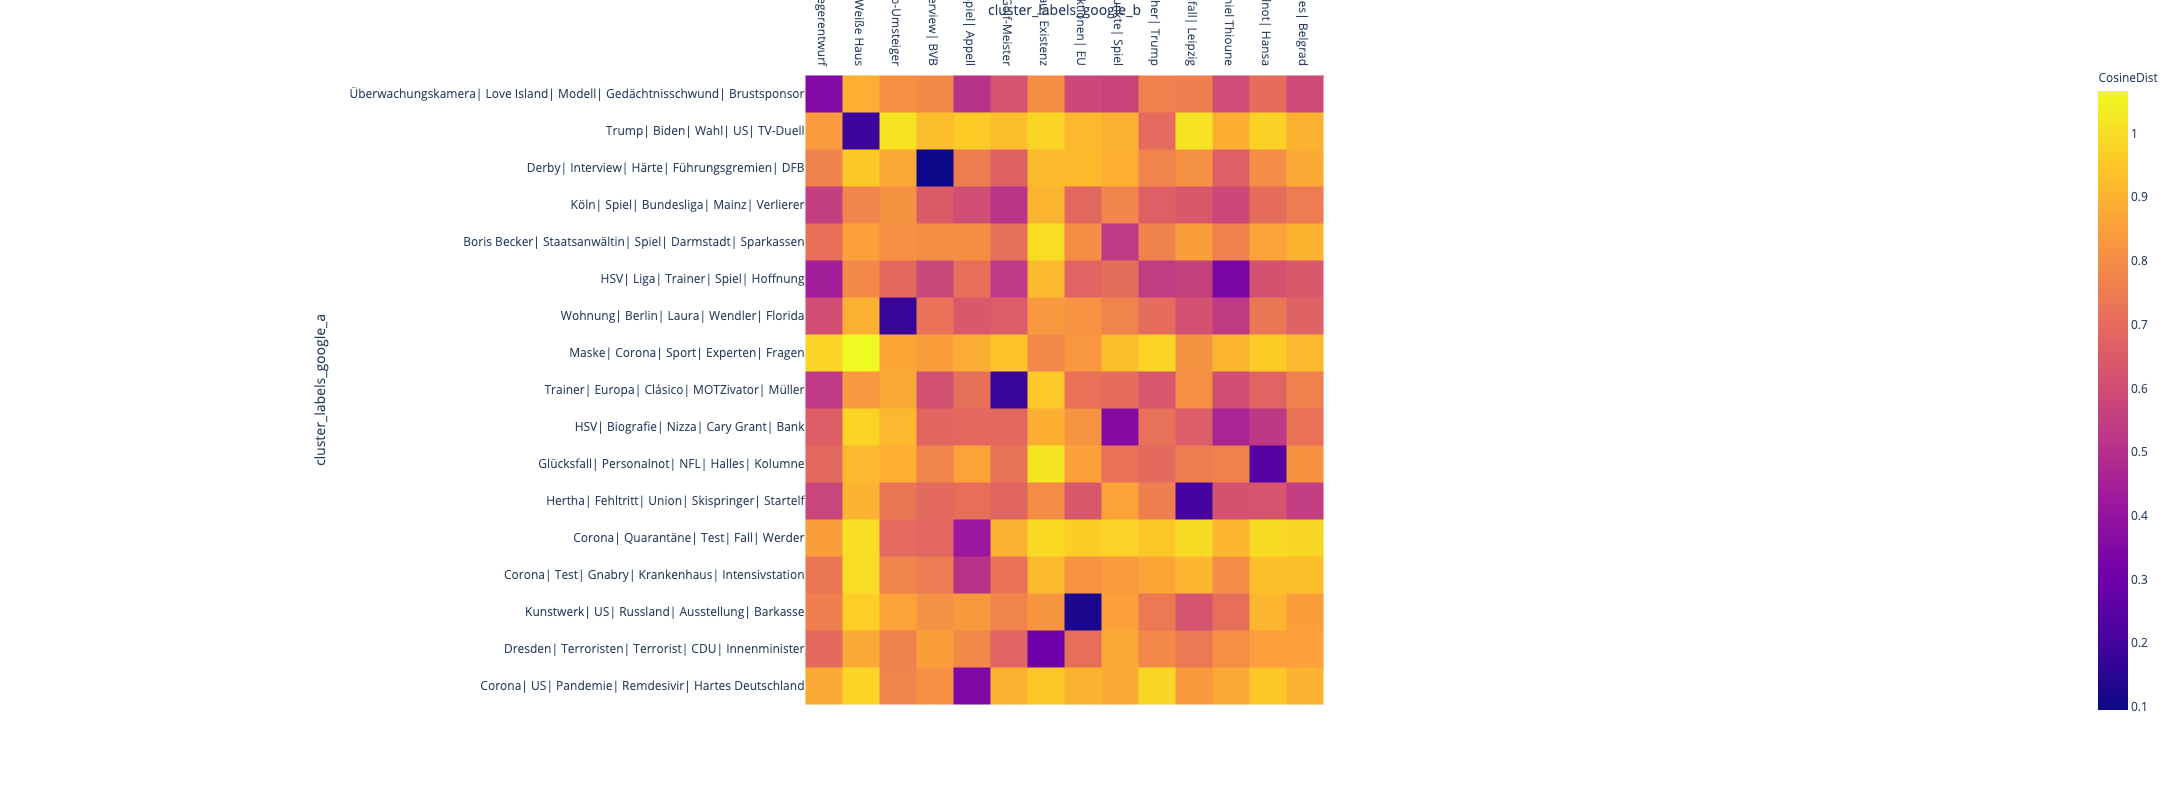

In [475]:
import plotly.express as px
data= cdist(np.stack(cluster_labels_google_a.merged_headline_embedding.values),np.stack(cluster_labels_google_b.merged_headline_embedding.values),"cosine")
fig = px.imshow(data,
                labels=dict(x="cluster_labels_google_b", y="cluster_labels_google_a", color="CosineDist"),
                x=cluster_labels_google_b.TopWords.to_list(),
                y=cluster_labels_google_a.TopWords.to_list()
               )
fig.update_xaxes(side="top")
fig.update_layout(height=800)

fig.show()

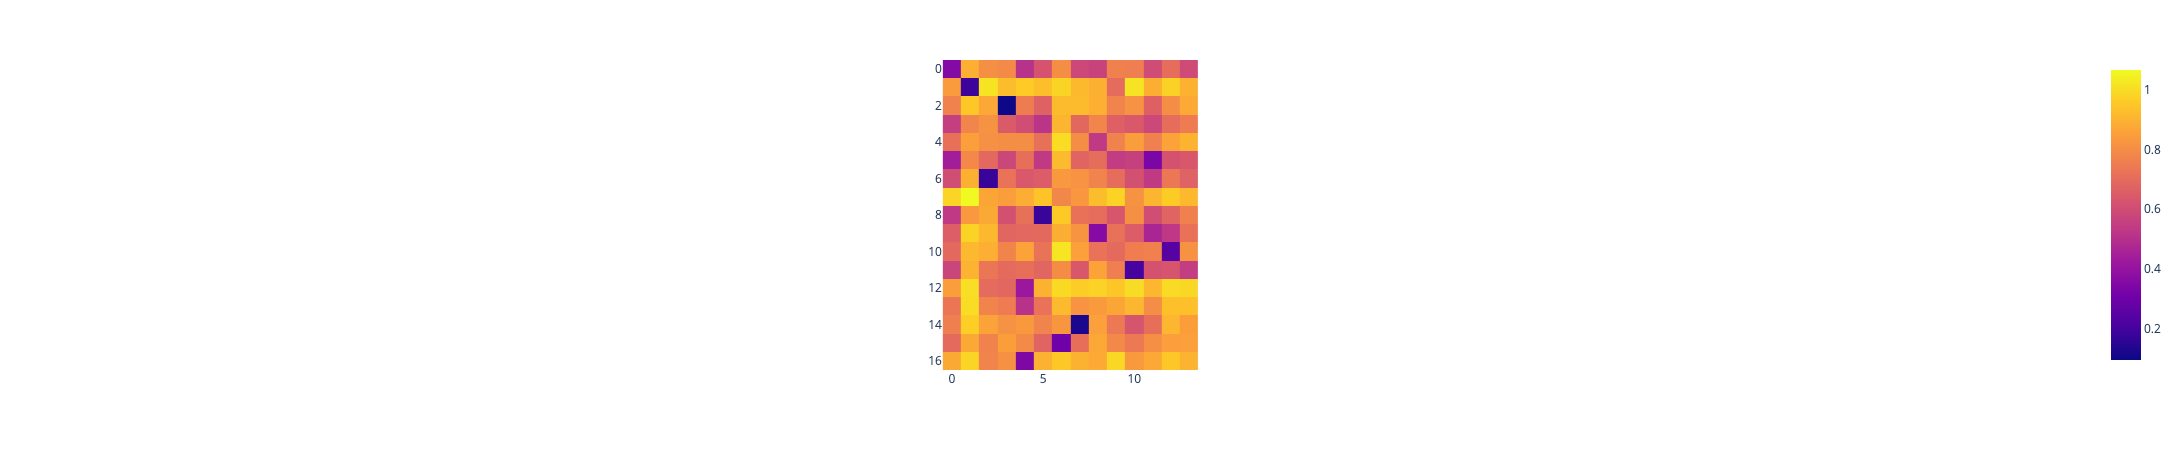

In [469]:

fig = px.imshow(cdist(np.stack(cluster_labels_google_a.merged_headline_embedding.values),np.stack(cluster_labels_google_b.merged_headline_embedding.values),"cosine"))
fig.show()

In [396]:
['a','c']+["va",'as']+["ss","s"]*2

['a', 'c', 'va', 'as', 'ss', 's', 'ss', 's']

In [385]:
# PCA Dim Reduction
pca =  PCA(n_components = 3)
X_train = embeddings_a - np.mean(embeddings_a)
X_new_final = pca.fit_transform(embeddings_a)

# PCA to do Post-Processing
pca =  PCA(n_components = 3)
X_new = X_new_final - np.mean(embeddings_a)
X_new = pca.fit_transform(X_new)
Ufit = pca.components_


for i, x in enumerate(embeddings):
        for u in Ufit[0:3]:
            embeddings[i] = embeddings[i] - np.dot(u.transpose(),embeddings[i]) * u 


NameError: name 'embeddings' is not defined